In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import emcee 

from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, ShuffleSplit, KFold

from scipy import stats

from math import *
import sys
import re
import os
from itertools import chain

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm

In [2]:
np.random.seed(0) # for reproducibility 

In [3]:
import seaborn as sns
sns.set(style="ticks", palette="muted", rc={"xtick.bottom" : True, "ytick.left" : True})
plt.style.use('matplotlibrc')

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
DF = pd.read_table('../regression/classical/models_cep.dat', sep='\t')
DF.drop(columns=['Mode'], inplace=True)
DF = DF[DF['M'] < 9]
pd.set_option('display.max_columns', 500)

DF['Period'] = np.log10(DF['Period'])
DF.rename(columns={'Period':'logP'}, inplace=True)

DF['W']  = DF['I_M0'] - 1.55 * (DF['V_M0'] - DF['I_M0'])
DF['VI'] = DF['V_M0'] - DF['I_M0']

DF['logR'] = np.log10(np.sqrt(10**DF['logL']) * (DF['Teff']/5777)**-2)

print(DF.columns)
DF

Index(['M', 'Z', 'logR', 'logL', 'Teff', 'logP', 'I_Amplitude', 'I_Skewness',
       'I_acuteness', 'I_R21', 'I_R31', 'I_M0', 'I_A1', 'I_A2', 'I_A3',
       'V_Amplitude', 'V_Skewness', 'V_acuteness', 'V_R21', 'V_R31', 'V_M0',
       'V_A1', 'V_A2', 'V_A3', 'W', 'VI'],
      dtype='object')


,M,Z,logR,logL,Teff,logP,I_Amplitude,I_Skewness,I_acuteness,I_R21,I_R31,I_M0,I_A1,I_A2,I_A3,V_Amplitude,V_Skewness,V_acuteness,V_R21,V_R31,V_M0,V_A1,V_A2,V_A3,W,VI
0,4.6,0.008,1.477102,3.02,6000,0.466380,0.552,2.571,1.329,0.43929,0.15010,-3.38631,0.21697,0.09531,0.03257,0.882,2.368,1.830,0.44330,0.15349,-2.74358,0.34335,0.15220,0.05270,-4.382541,0.64273
1,4.6,0.008,1.477102,3.02,6000,0.466650,0.800,3.099,1.551,0.54260,0.26072,-3.36715,0.27487,0.14915,0.07166,1.298,2.969,2.134,0.54981,0.26784,-2.71277,0.43298,0.23806,0.11597,-4.381439,0.65438
2,4.6,0.008,1.491701,3.02,5900,0.490475,0.440,2.425,0.921,0.37955,0.11013,-3.40824,0.18830,0.07147,0.02074,0.678,2.087,1.341,0.38871,0.11579,-2.73952,0.29563,0.11492,0.03423,-4.444756,0.66872
3,4.6,0.008,1.491701,3.02,5900,0.490745,0.691,3.717,1.143,0.51889,0.22975,-3.39157,0.25519,0.13242,0.05863,1.085,2.496,1.791,0.52955,0.23697,-2.71144,0.39741,0.21045,0.09417,-4.445771,0.68013
4,4.6,0.008,1.506549,3.02,5800,0.514472,0.317,1.950,0.761,0.32980,0.13680,-3.42835,0.14776,0.04873,0.02021,0.501,3.309,1.088,0.34265,0.14114,-2.73490,0.23427,0.08027,0.03307,-4.503197,0.69345
5,4.6,0.008,1.506549,3.02,5800,0.515287,0.561,3.548,0.815,0.45976,0.19837,-3.41423,0.23158,0.10647,0.04594,0.863,3.032,1.273,0.47535,0.20595,-2.70878,0.35680,0.16960,0.07348,-4.507678,0.70545
6,4.6,0.008,1.521655,3.02,5700,0.539598,0.197,2.598,0.772,0.30496,0.13906,-3.44669,0.09311,0.02840,0.01295,0.336,2.448,1.139,0.31027,0.13521,-2.72857,0.15312,0.04751,0.02070,-4.559776,0.71812
7,4.6,0.008,1.521655,3.02,5700,0.540138,0.470,9.423,0.687,0.40808,0.20670,-3.43443,0.19822,0.08089,0.04097,0.744,8.712,1.184,0.42691,0.21526,-2.70324,0.30525,0.13032,0.06571,-4.567775,0.73119
8,4.6,0.008,1.537029,3.02,5600,0.565515,0.403,7.699,0.726,0.40512,0.24458,-3.45241,0.15827,0.06412,0.03871,0.638,7.132,1.252,0.42260,0.24895,-2.69574,0.24744,0.10457,0.06160,-4.625248,0.75667
9,4.6,0.008,1.552679,3.02,5500,0.590934,0.286,4.781,0.864,0.42011,0.24556,-3.46875,0.11408,0.04793,0.02801,0.461,2.677,1.398,0.41801,0.23619,-2.68691,0.18560,0.07758,0.04384,-4.680602,0.78184


In [6]:
y_columns = ['logP', 
       'I_Amplitude', 'I_Skewness', 'I_acuteness', 
       'V_Amplitude', 'V_Skewness', 'V_acuteness', 
       'I_A1', 'I_A2', 'I_A3', 
       'V_A1', 'V_A2', 'V_A3']

X_columns = ['M', 'logR', 'logL', 'Teff', 'I_M0', 'V_M0', 'VI', 'W']

Visualize grid of models

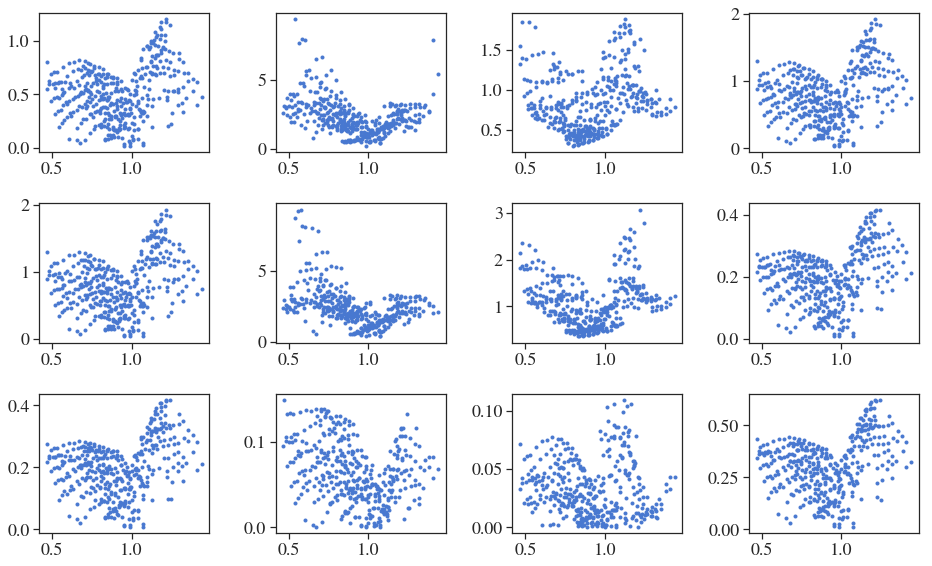

In [7]:
#sns.pairplot(DF[y_columns])
fig, ax = plt.subplots(3, 4, squeeze=True, figsize=(6.64306*2,4.10318716*2))
for i, ax_row in enumerate(ax):
    for j, axes in enumerate(ax_row):
        axes.plot(DF['logP'], DF[y_columns].iloc[:,1+3*i+j], '.')


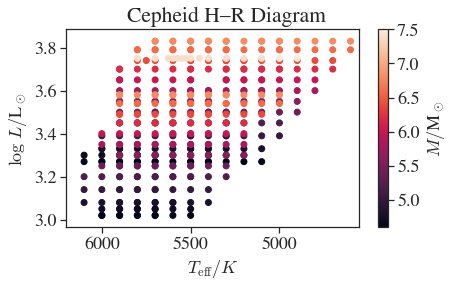

In [8]:
plt.suptitle('Cepheid H–R Diagram', y=0.99)
plt.scatter(DF['Teff'], DF['logL'], c=DF['M'])
plt.xlabel('$T_{\mathrm{eff}}/K$')
plt.ylabel('$\log\;L/$L$_\odot$')
plt.colorbar(label='$M/$M$_\odot$')
plt.xlim([6200, 4550])

plt.savefig('HR.pdf', bbox_inches='tight')
plt.show()

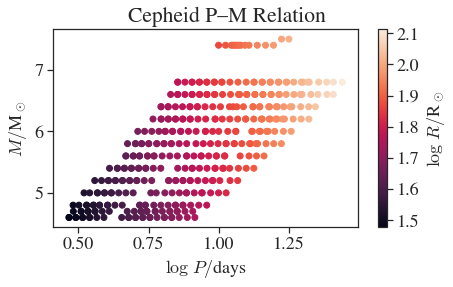

In [9]:
plt.suptitle('Cepheid P–M Relation', y=0.99)
plt.scatter(DF['logP'], DF['M'], c=DF['logR'])
plt.xlabel('$\log\;P/$days')
plt.ylabel('$M/$M$_\odot$')
plt.colorbar(label='$\log\;R/$R$_\odot$')

plt.savefig('PMR.pdf', bbox_inches='tight')
plt.show()

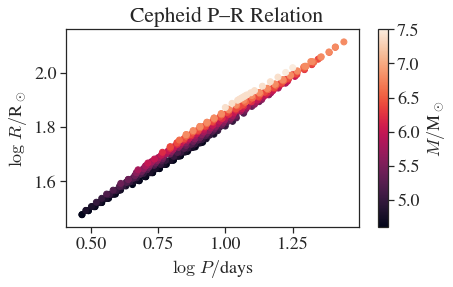

In [10]:
plt.suptitle('Cepheid P–R Relation', y=0.99)
plt.scatter(DF['logP'], DF['logR'], c=DF['M'])
plt.ylabel('$\log\;R/$R$_\odot$')
plt.xlabel('$\log\;P/$days')
plt.colorbar(label='$M/$M$_\odot$')

plt.savefig('PRM.pdf', bbox_inches='tight')
plt.show()

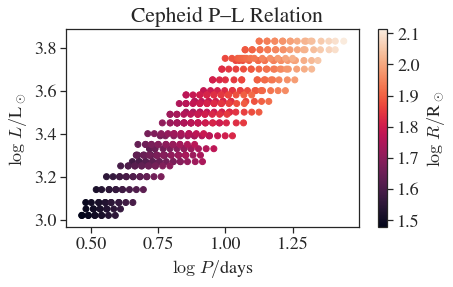

In [11]:
plt.suptitle('Cepheid P–L Relation', y=0.99)
plt.scatter(DF['logP'], DF['logL'], c=DF['logR'])
plt.ylabel('$\log\;L/$L$_\odot$')
plt.xlabel('$\log\;P/$days')
plt.colorbar(label='$\log\;R/$R$_\odot$')

plt.savefig('PL.pdf', bbox_inches='tight')
plt.show()

Cross validation

In [12]:
np.random.seed(0) 
splits = KFold(n_splits=2, shuffle=True, random_state=0).split(DF)

ml = TransformedTargetRegressor(regressor=Pipeline(
            [('scaler', RobustScaler()), 
             ('mlp', MLPRegressor(hidden_layer_sizes=(100, 100), 
                                  max_iter=2000, activation='relu', solver='lbfgs', tol=1e-7))]),
         transformer=RobustScaler())
lm = LinearRegression()

ml_preds = {} 
lm_preds = {} 

for split in splits:
    training_idx, testing_idx = split
    
    ml.fit(DF.iloc[training_idx][y_columns], DF.iloc[training_idx][X_columns])
    ml_pred = ml.predict(DF.iloc[testing_idx][y_columns].values)
    
    lm.fit(DF.iloc[training_idx][['logP']],  DF.iloc[training_idx][X_columns])
    lm_pred = lm.predict(DF.iloc[testing_idx]['logP'].values.reshape(-1, 1))
    
    for ii in range(len(testing_idx)):
        ml_preds[testing_idx[ii]] = ml_pred[ii]
        lm_preds[testing_idx[ii]] = lm_pred[ii]

ml_pred = np.array([ml_preds[ii] for ii in range(len(DF))])
lm_pred = np.array([lm_preds[ii] for ii in range(len(DF))])

In [13]:
for penalty in [0, 0.00001, 0.0001, 0.001, 0.01]:
    ml = TransformedTargetRegressor(regressor=Pipeline(
        [('scaler', RobustScaler()), 
         ('mlp', MLPRegressor(hidden_layer_sizes=(100, 100), 
                              max_iter=2000, activation='relu', solver='lbfgs', tol=1e-7,
                              alpha=penalty))]),
         transformer=RobustScaler())
    print(penalty, cross_val_score(ml, DF[y_columns], DF[X_columns], cv=KFold(n_splits=2, shuffle=True, random_state=0)))

0 [0.89920164 0.84726445]
1e-05 [0.90443243 0.84731028]
0.0001 [0.91943472 0.8606015 ]
0.001 [0.8964787  0.84558117]
0.01 [0.90326339 0.86531132]


Compute R^2, standard deviations, and percentages of improved estimates 

In [14]:
all_r2s = []
all_sds = []

for pred in (ml_pred, lm_pred):
    
    r2s = []
    sds = []
    
    for idx, name in enumerate(X_columns):
        std = np.array(np.array(pred[:,idx]) - DF[name]).std()
        sds += [std]
        
        SS_tot = np.sum((DF[name] - DF[name].mean())**2)
        SS_res = np.sum((pred[:,idx] - DF[name].values)**2)
        R2 = 1-SS_res/SS_tot
        
        r2s += [R2]
    
    all_r2s += [r2s]
    all_sds += [sds]

all_r2s = np.array(all_r2s)
all_sds = np.array(all_sds)

In [15]:
ml_err = []
lm_err = []

for idx, name in enumerate(X_columns):
    ml_errs = abs(np.array(ml_pred[:,idx]) - DF[name])
    lm_errs = abs(np.array(lm_pred[:,idx]) - DF[name])
    ml_err += [ml_errs]
    lm_err += [lm_errs]

ml_err = np.array(ml_err)
lm_err = np.array(lm_err)

In [16]:
for idx, name in enumerate(X_columns): 
    print(name, int(np.round(((lm_err[idx,:] >= ml_err[idx,:]).sum()) / lm_err.shape[1] * 100, 0))) 

M 74
logR 74
logL 81
Teff 85
I_M0 81
V_M0 82
VI 84
W 76


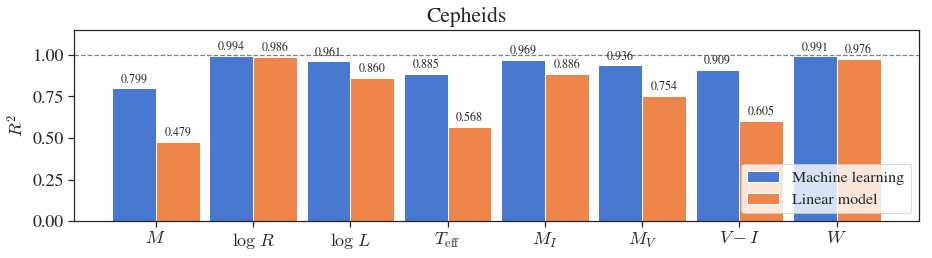

In [17]:
labels = ['$M$', '$\log\;R$', '$\log\;L$', '$T_{\\rm{eff}}$', '$M_I$', '$M_V$', '$V-I$', '$W$']

plt.rcParams["font.size"] = 18
x = np.arange(len(labels))  # the label locations
width = 0.45  # the width of the bars

fig, ax = plt.subplots(figsize=(6.64306*2,4.10318716*0.9))
plt.suptitle('Cepheids', y=0.99)
rects1 = ax.bar(x - width/2, all_r2s[0,:], width, label='Machine learning')
rects2 = ax.bar(x + width/2, all_r2s[1,:], width, label='Linear model')

plt.axhline(1, c='gray', linewidth=1.25, linestyle='--')

ax.set_ylabel('$R^2$')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim([0, 1.15])
ax.legend(loc='lower right')

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('%.3f' % height,
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.rcParams["font.size"] = 12
autolabel(rects1)
autolabel(rects2)
plt.rcParams["font.size"] = 18
#autolabel(rects3)

plt.savefig('R2-ML-LM.pdf')
plt.show()

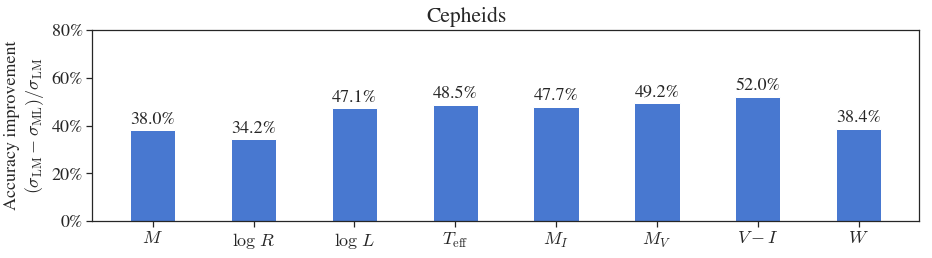

In [18]:
labels = ['$M$', '$\log\;R$', '$\log\;L$', '$T_{\\rm{eff}}$', '$M_I$', '$M_V$', '$V-I$', '$W$']

x = np.arange(len(labels))
width = 0.45

fig, ax = plt.subplots(figsize=(6.64306*2,4.10318716*0.9))
plt.suptitle('Cepheids', y=0.99)
rects1 = ax.bar(x, (all_sds[1,:] - all_sds[0,:])/all_sds[1,:], width)

ax.set_ylabel('Accuracy improvement\n$(\sigma_{\\rm{LM}} - \sigma_{\\rm{ML}}) / \sigma_{\\rm{LM}}$')
ax.set_xticks(x)
ax.set_xticklabels(labels)

ax.set_ylim([0, 0.8])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8])
locs, labels = plt.yticks()
ax.set_yticklabels([str(int(loc*100)) + '%' for loc in locs])

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('%.1f' % (height*100) + '%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), 
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)

plt.savefig('sds-ML-LM.pdf')
plt.show()

In [19]:
ml_stds = []
ml_r2s = []

for idx, name in enumerate(X_columns):
    std = np.array(np.array(ml_pred[:,idx]) - DF[name]).std()
    print(name, 'std: %.3f' % std)
    ml_stds += [std]
    
    SS_tot = np.sum((DF[name] - DF[name].mean())**2)
    SS_res = np.sum((ml_pred[:,idx] - DF[name].values)**2)
    R2 = 1-SS_res/SS_tot
    ml_r2s += [R2]
    
    print(name, 'R2: %.3f' % R2)

M std: 0.350
M R2: 0.799
logR std: 0.011
logR R2: 0.994
logL std: 0.044
logL R2: 0.961
Teff std: 107.694
Teff R2: 0.885
I_M0 std: 0.101
I_M0 R2: 0.969
V_M0 std: 0.131
V_M0 R2: 0.936
VI std: 0.033
VI R2: 0.909
W std: 0.065
W R2: 0.991


In [20]:
lm_stds = []
lm_r2s = []

for idx, name in enumerate(X_columns):
    std = np.array(np.array(lm_pred[:,idx]) - DF[name]).std()
    print(name, 'std: %.3f' % std)
    lm_stds += [std]
    
    SS_tot = np.sum((DF[name] - DF[name].mean())**2)
    SS_res = np.sum((lm_pred[:,idx] - DF[name].values)**2)
    R2 = 1-SS_res/SS_tot
    lm_r2s += [R2]
    
    print(name, 'R2: %.3f' % R2)

M std: 0.564
M R2: 0.479
logR std: 0.017
logR R2: 0.986
logL std: 0.084
logL R2: 0.860
Teff std: 209.088
Teff R2: 0.568
I_M0 std: 0.193
I_M0 R2: 0.886
V_M0 std: 0.258
V_M0 R2: 0.754
VI std: 0.070
VI R2: 0.605
W std: 0.105
W R2: 0.976


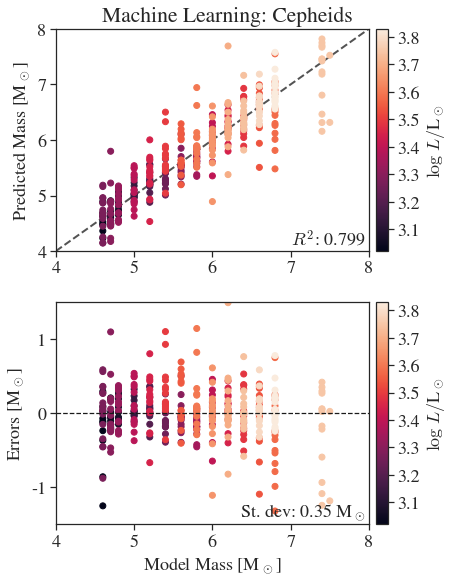

In [21]:
var = 'M'
lims = [4, 8]

plt.figure(figsize=(6.64306,4.10318716*2))
plt.suptitle('Machine Learning: Cepheids', y=0.995)

ax = plt.subplot(2,1,1)
plt.scatter(DF[var], ml_pred[:,X_columns.index(var)], c=DF['logL'])
plt.plot([lims[0],lims[1]], [lims[0],lims[1]], 'k--', alpha=0.75, zorder=0)
plt.ylabel('Predicted Mass [M$_\odot$]')
plt.xlim(lims)
plt.ylim(lims)
plt.colorbar(label='$\log\;L/$L$_\odot$', pad=0.02)
plt.text(7, 4.1, '$R^2$: %.3f' % ml_r2s[X_columns.index(var)])

ax2 = plt.subplot(2,1,2, sharex=ax)
plt.axhline(0, c='k', ls='--', linewidth=1.25)
plt.scatter(DF[var], ml_pred[:,X_columns.index(var)] - DF[var], c=DF['logL'])
plt.xlabel('Model Mass [M$_\odot$]')
plt.ylabel('Errors [M$_\odot$]')
plt.colorbar(label='$\log\;L/$L$_\odot$', pad=0.02)
plt.xlim(lims)
plt.ylim([-1.5, 1.5])
ax2.set_yticks([-1, 0, 1])
ax2.set_yticklabels([-1, 0, 1])
plt.text(6.35, -1.4, 'St. dev: %.2f M$_\odot$' % ml_stds[X_columns.index(var)])

plt.savefig('CEP-ML-mass.pdf')#, bbox_inches='tight')
plt.show()

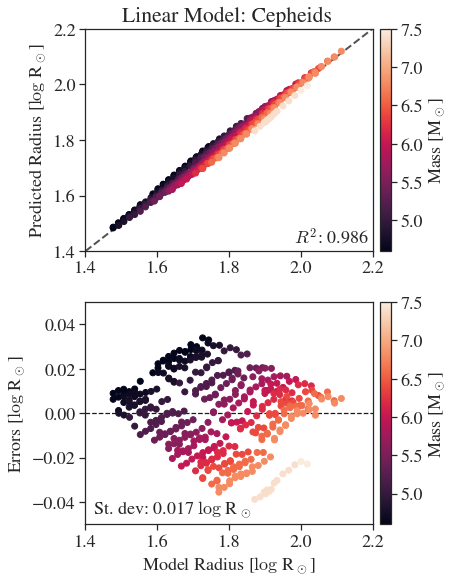

In [22]:
var = 'logR'
lims = [1.4, 2.2]

fig = plt.figure(figsize=(6.64306,4.10318716*2))
plt.suptitle('Linear Model: Cepheids', y=0.995)

ax = plt.subplot(2,1,1)
plt.scatter(DF[var], lm_pred[:,X_columns.index(var)], c=DF['M'])
plt.plot([lims[0],lims[1]], [lims[0],lims[1]], 'k--', alpha=0.75, zorder=0)
plt.ylabel('Predicted Radius [$\log$ R$_\odot$]')
plt.xlim(lims)
plt.ylim(lims)
plt.colorbar(label='Mass [M$_\odot$]', pad=0.02)
plt.text(1.98, 1.43, '$R^2$: %.3f' % lm_r2s[X_columns.index(var)])

ax2 = plt.subplot(2,1,2, sharex=ax)
plt.plot([lims[0], lims[1]], [0, 0], 'k--', zorder=0, linewidth=1.25)
plt.scatter(DF[var], lm_pred[:,X_columns.index(var)] - DF[var], c=DF['M'])
plt.colorbar(label='Mass [M$_\odot$]', pad=0.02)
plt.xlabel('Model Radius [$\log$ R$_\odot$]')
plt.ylabel('Errors [$\log$ R$_\odot$]')
plt.xlim(lims)
plt.ylim([-0.05, 0.05])
plt.text(1.42, -0.045, 'St. dev: %.3f $\log$ R$_\odot$' % lm_stds[X_columns.index(var)])

plt.savefig('CEP-LM-radius.pdf')#, bbox_inches='tight')
plt.show()

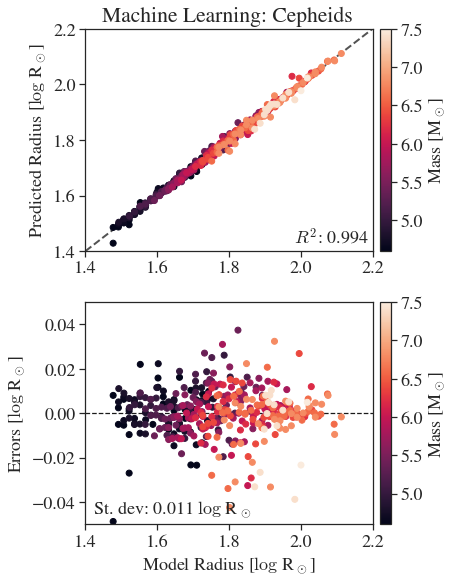

In [23]:
var = 'logR'
lims = [1.4, 2.2]

plt.figure(figsize=(6.64306,4.10318716*2))
plt.suptitle('Machine Learning: Cepheids', y=0.995)

ax = plt.subplot(2,1,1)
plt.scatter(DF[var], ml_pred[:,X_columns.index(var)], c=DF['M'])
plt.plot([lims[0],lims[1]], [lims[0],lims[1]], 'k--', alpha=0.75, zorder=0)
plt.ylabel('Predicted Radius [$\log$ R$_\odot$]')
plt.xlim(lims)
plt.ylim(lims)
plt.colorbar(label='Mass [M$_\odot$]', pad=0.02)
plt.text(1.98, 1.43, '$R^2$: %.3f' % ml_r2s[X_columns.index(var)])

ax2 = plt.subplot(2,1,2, sharex=ax)
plt.plot([lims[0], lims[1]], [0, 0], 'k--', zorder=0, linewidth=1.25)
plt.scatter(DF[var], ml_pred[:,X_columns.index(var)] - DF[var], c=DF['M'])
plt.colorbar(label='Mass [M$_\odot$]', pad=0.02)
plt.xlabel('Model Radius [$\log$ R$_\odot$]')
plt.ylabel('Errors [$\log$ R$_\odot$]')
plt.xlim(lims)
plt.ylim([-0.05, 0.05])
plt.text(1.42, -0.045, 'St. dev: %.3f $\log$ R$_\odot$' % ml_stds[X_columns.index(var)])

plt.savefig('CEP-ML-radius.pdf')#, bbox_inches='tight')
plt.show()

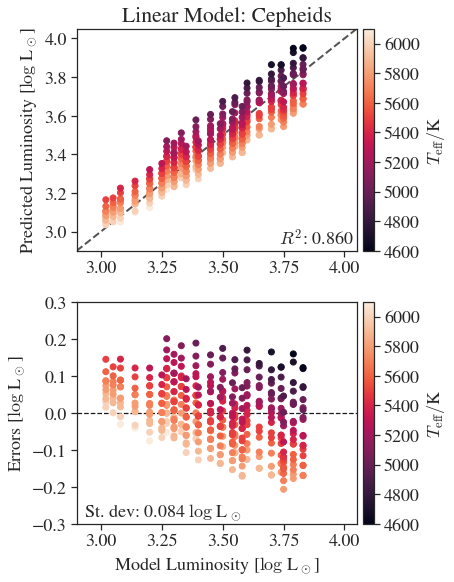

In [24]:
var = 'logL'
lims = [2.9, 4.05]

fig = plt.figure(figsize=(6.64306,4.10318716*2))
plt.suptitle('Linear Model: Cepheids', y=0.995)

ax = plt.subplot(2,1,1)
plt.scatter(DF[var], lm_pred[:,X_columns.index(var)], c=DF['Teff'])
plt.plot([lims[0],lims[1]], [lims[0],lims[1]], 'k--', alpha=0.75, zorder=0)
plt.ylabel('Predicted Luminosity [$\log$ L$_\odot$]')
plt.xlim(lims)
plt.ylim(lims)
plt.colorbar(label='$T_{\\rm{eff}}/$K', pad=0.02)
plt.text(3.73, 2.93, '$R^2$: %.3f' % lm_r2s[X_columns.index(var)])

ax2 = plt.subplot(2,1,2, sharex=ax)
plt.plot([lims[0], lims[1]], [0, 0], 'k--', zorder=0, linewidth=1.25)
plt.scatter(DF['logL'], lm_pred[:,X_columns.index(var)] - DF['logL'], c=DF['Teff'])
plt.colorbar(label='$T_{\\rm{eff}}/$K', pad=0.02)
plt.xlabel('Model Luminosity [$\log$ L$_\odot$]')
plt.ylabel('Errors [$\log$ L$_\odot$]')
plt.xlim(lims)
plt.ylim([-0.3, 0.3])
plt.text(2.93, -0.28, 'St. dev: %.3f $\log$ L$_\odot$' % lm_stds[X_columns.index(var)])

plt.savefig('CEP-LM-luminosity.pdf')#, bbox_inches='tight')
plt.show()

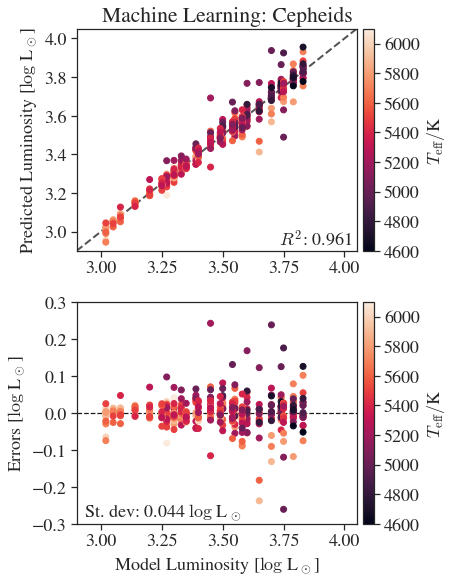

In [25]:
lims = [2.9, 4.05]

plt.figure(figsize=(6.64306,4.10318716*2))
plt.suptitle('Machine Learning: Cepheids', y=0.995)

ax = plt.subplot(2,1,1)
plt.scatter(DF[var], ml_pred[:,X_columns.index(var)], c=DF['Teff'])
plt.plot([lims[0],lims[1]], [lims[0],lims[1]], 'k--', alpha=0.75, zorder=0)
plt.ylabel('Predicted Luminosity [$\log$ L$_\odot$]')
plt.xlim(lims)
plt.ylim(lims)
plt.colorbar(label='$T_{\\rm{eff}}/$K', pad=0.02)
plt.text(3.73, 2.93, '$R^2$: %.3f' % ml_r2s[X_columns.index(var)])

ax2 = plt.subplot(2,1,2, sharex=ax)
plt.plot([lims[0], lims[1]], [0, 0], 'k--', zorder=0, linewidth=1.25)
plt.scatter(DF['logL'], ml_pred[:,X_columns.index(var)] - DF['logL'], c=DF['Teff'])
plt.colorbar(label='$T_{\\rm{eff}}/$K', pad=0.02)
plt.xlabel('Model Luminosity [$\log$ L$_\odot$]')
plt.ylabel('Errors [$\log$ L$_\odot$]')
plt.xlim(lims)
plt.ylim([-0.3, 0.3])
plt.text(2.93, -0.28, 'St. dev: %.3f $\log$ L$_\odot$' % ml_stds[X_columns.index(var)])

plt.savefig('CEP-ML-luminosity.pdf')#, bbox_inches='tight')
plt.show()

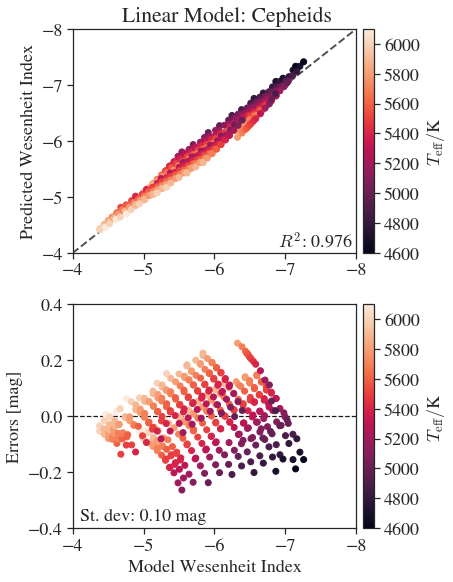

In [26]:
var = 'W'
lims = [-4, -8]

fig = plt.figure(figsize=(6.64306,4.10318716*2))
plt.suptitle('Linear Model: Cepheids', y=0.995)

ax = plt.subplot(2,1,1)
plt.scatter(DF[var], lm_pred[:,X_columns.index(var)], c=DF['Teff'])
plt.plot([lims[0],lims[1]], [lims[0],lims[1]], 'k--', alpha=0.75, zorder=0)
plt.ylabel('Predicted Wesenheit Index')
plt.xlim(lims)
plt.ylim(lims)
plt.colorbar(label='$T_{\\rm{eff}}/$K', pad=0.02)
plt.text(-6.9, -4.1, '$R^2$: %.3f' % lm_r2s[X_columns.index(var)])

ax2 = plt.subplot(2,1,2, sharex=ax)
plt.plot([lims[0], lims[1]], [0, 0], 'k--', zorder=0, linewidth=1.25)
plt.scatter(DF[var], lm_pred[:,X_columns.index(var)] - DF[var], c=DF['Teff'])
plt.colorbar(label='$T_{\\rm{eff}}/$K', pad=0.02)
plt.xlabel('Model Wesenheit Index')
plt.ylabel('Errors [mag]')
plt.xlim(lims)
plt.ylim([-0.4, 0.4])
plt.text(-4.1, -0.37, 'St. dev: %.2f mag' % lm_stds[X_columns.index(var)])

plt.savefig('CEP-LM-W.pdf')#, bbox_inches='tight')
plt.show()

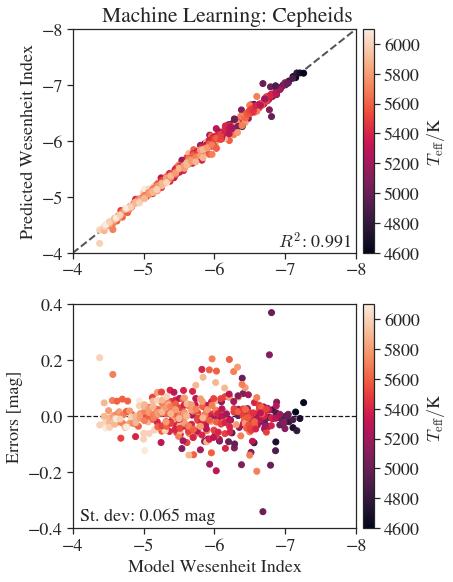

In [27]:
var = 'W'
lims = [-4, -8]

fig = plt.figure(figsize=(6.64306,4.10318716*2))
plt.suptitle('Machine Learning: Cepheids', y=0.995)

ax = plt.subplot(2,1,1)
plt.scatter(DF[var], ml_pred[:,X_columns.index(var)], c=DF['Teff'])
plt.plot([lims[0],lims[1]], [lims[0],lims[1]], 'k--', alpha=0.75, zorder=0)
plt.ylabel('Predicted Wesenheit Index')
plt.xlim(lims)
plt.ylim(lims)
plt.colorbar(label='$T_{\\rm{eff}}/$K', pad=0.02)
plt.text(-6.9, -4.1, '$R^2$: %.3f' % ml_r2s[X_columns.index(var)])

ax2 = plt.subplot(2,1,2, sharex=ax)
plt.plot([lims[0], lims[1]], [0, 0], 'k--', zorder=0, linewidth=1.25)
plt.scatter(DF[var], ml_pred[:,X_columns.index(var)] - DF[var], c=DF['Teff'])
plt.colorbar(label='$T_{\\rm{eff}}/$K', pad=0.02)
plt.xlabel('Model Wesenheit Index')
plt.ylabel('Errors [mag]')
plt.xlim(lims)
plt.ylim([-0.4, 0.4])
plt.text(-4.1, -0.37, 'St. dev: %.3f mag' % ml_stds[X_columns.index(var)])

plt.savefig('CEP-ML-W.pdf')#, bbox_inches='tight')
plt.show()

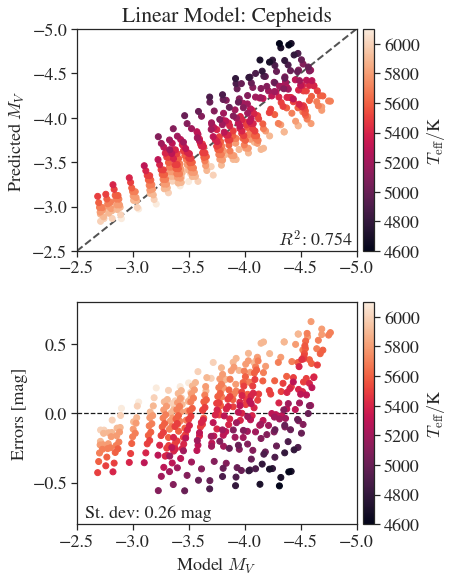

In [28]:
var = 'V_M0'
lims = [-2.5, -5]

fig = plt.figure(figsize=(6.64306,4.10318716*2))
plt.suptitle('Linear Model: Cepheids', y=0.995)

ax = plt.subplot(2,1,1)
plt.scatter(DF[var], lm_pred[:,X_columns.index(var)], c=DF['Teff'])
plt.plot([lims[0],lims[1]], [lims[0],lims[1]], 'k--', alpha=0.75, zorder=0)
plt.ylabel('Predicted $M_V$')
plt.xlim(lims)
plt.ylim(lims)
plt.colorbar(label='$T_{\\rm{eff}}/$K', pad=0.02)
plt.text(-4.3, -2.56, '$R^2$: %.3f' % lm_r2s[X_columns.index(var)])

ax2 = plt.subplot(2,1,2, sharex=ax)
plt.plot([lims[0], lims[1]], [0, 0], 'k--', zorder=0, linewidth=1.25)
plt.scatter(DF[var], lm_pred[:,X_columns.index(var)] - DF[var], c=DF['Teff'])
plt.colorbar(label='$T_{\\rm{eff}}/$K', pad=0.02)
plt.xlabel('Model $M_V$')
plt.ylabel('Errors [mag]')
plt.xlim(lims)
plt.ylim([-0.8, 0.8])
plt.text(-2.57, -0.75, 'St. dev: %.2f mag' % lm_stds[X_columns.index(var)])

plt.savefig('CEP-LM-V_M0.pdf')#, bbox_inches='tight')
plt.show()

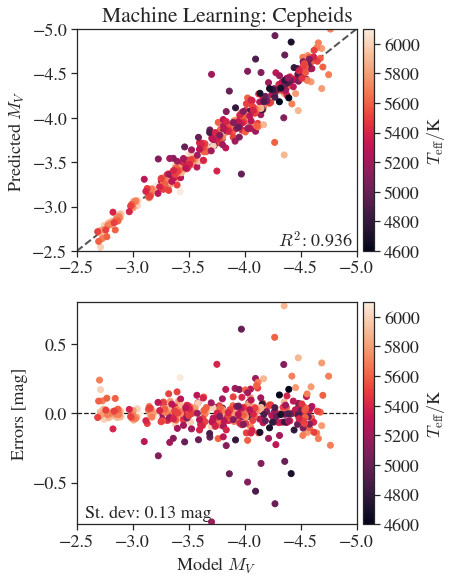

In [29]:
var = 'V_M0'
lims = [-2.5, -5]

fig = plt.figure(figsize=(6.64306,4.10318716*2))
plt.suptitle('Machine Learning: Cepheids', y=0.995)

ax = plt.subplot(2,1,1)
plt.scatter(DF[var], ml_pred[:,X_columns.index(var)], c=DF['Teff'])
plt.plot([lims[0],lims[1]], [lims[0],lims[1]], 'k--', alpha=0.75, zorder=0)
plt.ylabel('Predicted $M_V$')
plt.xlim(lims)
plt.ylim(lims)
plt.colorbar(label='$T_{\\rm{eff}}/$K', pad=0.02)
plt.text(-4.3, -2.56, '$R^2$: %.3f' % ml_r2s[X_columns.index(var)])

ax2 = plt.subplot(2,1,2, sharex=ax)
plt.plot([lims[0], lims[1]], [0, 0], 'k--', zorder=0, linewidth=1.25)
plt.scatter(DF[var], ml_pred[:,X_columns.index(var)] - DF[var], c=DF['Teff'])
plt.colorbar(label='$T_{\\rm{eff}}/$K', pad=0.02)
plt.xlabel('Model $M_V$')
plt.ylabel('Errors [mag]')
plt.xlim(lims)
plt.ylim([-0.8, 0.8])
plt.text(-2.57, -0.75, 'St. dev: %.2f mag' % ml_stds[X_columns.index(var)])

plt.savefig('CEP-ML-V_M0.pdf')#, bbox_inches='tight')
plt.show()

Significance testing

In [30]:
# (neural network with log P and lightcurve) vs (linear model with log P) with the Wilcoxon test 

for name in X_columns: 
    ml_err = abs(DF[name] - ml_pred[:,X_columns.index(name)])
    lm_err = abs(DF[name] - lm_pred[:,X_columns.index(name)])
    print(name, sp.stats.wilcoxon(lm_err, ml_err).pvalue)

M 4.8226885861573445e-28
logR 1.2904685567980838e-25
logL 7.410398478671702e-40
Teff 2.768046944534012e-45
I_M0 2.3024578991353531e-38
V_M0 2.873842493932314e-41
VI 4.765730830885012e-46
W 1.8762776320162059e-28


In [31]:
# (neural network with log P and lightcurve) vs (linear model with log P) with 5x2 cv test 

np.random.seed(0) 

ml = TransformedTargetRegressor(regressor=Pipeline(
            [('scaler', RobustScaler()), 
             ('mlp', MLPRegressor(hidden_layer_sizes=(100, 100), 
                                  max_iter=2000, activation='relu', solver='lbfgs', tol=1e-7))]),
         transformer=RobustScaler())
lm = LinearRegression()

first_p1 = 0 
s2s = []

for ii in range(5):
    ml_scores = []
    lm_scores = []
    
    cv = ShuffleSplit(n_splits=2, random_state=ii, train_size=0.5, test_size=0.5)
    
    for train_index, test_index in cv.split(DF):
        ml.fit(DF.iloc[train_index][y_columns], DF.iloc[train_index][X_columns])
        lm.fit(DF.iloc[train_index][['logP']],  DF.iloc[train_index][X_columns])
        
        ml_predict = ml.predict(DF.iloc[test_index][y_columns])
        lm_predict = lm.predict(DF.iloc[test_index][['logP']])
        
        ml_scores_ = []
        lm_scores_ = []
        
        for idx, name in enumerate(X_columns):
            SS_tot = np.sum((DF.iloc[test_index][name] - DF.iloc[test_index][name].mean())**2)
            
            ml_SS_res = np.sum((ml_predict[:,idx] - DF.iloc[test_index][name].values)**2)
            ml_R2 = 1-ml_SS_res/SS_tot
            #ml_scores_ += [ml_R2]
            ml_scores_ += [ml_SS_res]
            
            lm_SS_res = np.sum((lm_predict[:,idx] - DF.iloc[test_index][name].values)**2)
            lm_R2 = 1-lm_SS_res/SS_tot
            #lm_scores_ += [lm_R2]
            lm_scores_ += [lm_SS_res]
        
        ml_scores += [ml_scores_]
        lm_scores += [lm_scores_]
    
    ml_scores = np.array(ml_scores)
    lm_scores = np.array(lm_scores)
    
    p1 = ml_scores[0,:] - lm_scores[0,:]
    p2 = ml_scores[1,:] - lm_scores[1,:]
    p_bar = (p1 + p2)/2
    s2 = (p1 - p_bar)**2 + (p2 - p_bar)**2
    
    if ii == 0:
        first_p1 = p1
    s2s += [s2]

first_p1 = np.array(first_p1)
s2s = np.array(s2s)

for idx, name in enumerate(X_columns):
    p = stats.t.sf(np.abs(first_p1[idx]) / np.sqrt(1/5. * sum(s2s[:,idx])), 5)*2.
    print(name, '%.2E' % p) # '%.10f' % p)

M 9.64E-05
logR 4.37E-03
logL 3.03E-06
Teff 6.29E-06
I_M0 3.67E-06
V_M0 4.78E-06
VI 4.82E-06
W 1.57E-04


In [32]:
# (neural network with log P and lightcurve) vs (linear model with log P) with Wilcoxon signed-rank test 

np.random.seed(0) 

ml = TransformedTargetRegressor(regressor=Pipeline(
            [('scaler', RobustScaler()), 
             ('mlp', MLPRegressor(hidden_layer_sizes=(100, 100), 
                                  max_iter=2000, activation='relu', solver='lbfgs', tol=1e-7))]),
         transformer=RobustScaler())
lm = LinearRegression()

cv = ShuffleSplit(n_splits=2, random_state=0, train_size=0.5, test_size=0.5)
train_set, test_set = list(cv.split(DF))[0]

ml.fit(DF.iloc[train_set][y_columns], DF.iloc[train_set][X_columns])
lm.fit(DF.iloc[train_set][['logP']],  DF.iloc[train_set][X_columns])

ml_predict = ml.predict(DF.iloc[test_set][y_columns])
lm_predict = lm.predict(DF.iloc[test_set][['logP']])

for idx, name in enumerate(X_columns):
    ml_SE = (ml_predict[:,idx] - DF.iloc[test_set][name].values)**2
    lm_SE = (lm_predict[:,idx] - DF.iloc[test_set][name].values)**2
    
    wil = sp.stats.wilcoxon(ml_SE, lm_SE)
    print(name, ml_SE.mean() < lm_SE.mean(), wil.pvalue/2.) # one sided test 


M True 4.1581837797536337e-13
logR True 3.63728908382849e-14
logL True 6.160719974907984e-21
Teff True 5.654911569738892e-24
I_M0 True 5.818796617528765e-20
V_M0 True 3.652754351987831e-21
VI True 2.108630817227543e-23
W True 6.818718841112479e-14


In [33]:
# (neural network with log P and lightcurve) vs (linear model with log P and lightcurve) with 5x2cv test 

np.random.seed(0) 

ml = TransformedTargetRegressor(regressor=Pipeline(
            [('scaler', RobustScaler()), 
             ('mlp', MLPRegressor(hidden_layer_sizes=(100, 100), 
                                  max_iter=2000, activation='relu', solver='lbfgs', tol=1e-7))]),
         transformer=RobustScaler())
lm = LinearRegression()

first_p1 = 0 
s2s = []

for ii in range(5):
    ml_scores = []
    lm_scores = []
    
    cv = ShuffleSplit(n_splits=2, random_state=ii, train_size=0.5, test_size=0.5)
    
    for train_index, test_index in cv.split(DF):
        ml.fit(DF.iloc[train_index][y_columns], DF.iloc[train_index][X_columns])
        lm.fit(DF.iloc[train_index][y_columns], DF.iloc[train_index][X_columns])
        
        ml_predict = ml.predict(DF.iloc[test_index][y_columns])
        lm_predict = lm.predict(DF.iloc[test_index][y_columns])
        
        ml_scores_ = []
        lm_scores_ = []
        
        for idx, name in enumerate(X_columns):
            SS_tot = np.sum((DF.iloc[test_index][name] - DF.iloc[test_index][name].mean())**2)
            
            ml_SS_res = np.sum((ml_predict[:,idx] - DF.iloc[test_index][name].values)**2)
            ml_R2 = 1-ml_SS_res/SS_tot
            #ml_scores_ += [ml_R2]
            ml_scores_ += [ml_SS_res]
            
            lm_SS_res = np.sum((lm_predict[:,idx] - DF.iloc[test_index][name].values)**2)
            lm_R2 = 1-lm_SS_res/SS_tot
            #lm_scores_ += [lm_R2]
            lm_scores_ += [lm_SS_res]
        
        ml_scores += [ml_scores_]
        lm_scores += [lm_scores_]
    
    ml_scores = np.array(ml_scores)
    lm_scores = np.array(lm_scores)
    
    p1 = ml_scores[0,:] - lm_scores[0,:]
    p2 = ml_scores[1,:] - lm_scores[1,:]
    p_bar = (p1 + p2)/2
    s2 = (p1 - p_bar)**2 + (p2 - p_bar)**2
    
    if ii == 0:
        first_p1 = p1
    s2s += [s2]

first_p1 = np.array(first_p1)
s2s = np.array(s2s)

for idx, name in enumerate(X_columns):
    p = stats.t.sf(np.abs(first_p1[idx]) / np.sqrt(1/5. * sum(s2s[:,idx])), 5)/2. # one sided test 
    print(name, '%.2E' % p)

M 3.29E-04
logR 2.94E-03
logL 3.87E-04
Teff 3.76E-04
I_M0 6.87E-04
V_M0 5.52E-04
VI 2.97E-04
W 4.23E-04


In [34]:
# (neural network with log P and lightcurve) vs (linear model with log P and lightcurve) with Wilcoxon signed-rank test 

np.random.seed(0) 

ml = TransformedTargetRegressor(regressor=Pipeline(
            [('scaler', RobustScaler()), 
             ('mlp', MLPRegressor(hidden_layer_sizes=(100, 100), 
                                  max_iter=2000, activation='relu', solver='lbfgs', tol=1e-7))]),
         transformer=RobustScaler())
lm = LinearRegression()

cv = ShuffleSplit(n_splits=2, random_state=0, train_size=0.5, test_size=0.5)
train_set, test_set = list(cv.split(DF))[0]

ml.fit(DF.iloc[train_set][y_columns], DF.iloc[train_set][X_columns])
lm.fit(DF.iloc[train_set][y_columns], DF.iloc[train_set][X_columns])

ml_predict = ml.predict(DF.iloc[test_set][y_columns])
lm_predict = lm.predict(DF.iloc[test_set][y_columns])

for idx, name in enumerate(X_columns):
    ml_SE = (ml_predict[:,idx] - DF.iloc[test_set][name].values)**2
    lm_SE = (lm_predict[:,idx] - DF.iloc[test_set][name].values)**2
    
    wil = sp.stats.wilcoxon(ml_SE, lm_SE)
    print(name, ml_SE.mean() < lm_SE.mean(), wil.pvalue/2.) # one sided test 


M True 3.6221348278706677e-12
logR True 5.371970878763796e-13
logL True 3.3695494986483773e-16
Teff True 1.1229376543350066e-18
I_M0 True 1.880937254410796e-15
V_M0 True 2.497344286221803e-16
VI True 5.0889774862789716e-18
W True 8.964825529966717e-12


Now train on all models and run on real data 

In [35]:
np.random.seed(0) 

ml = TransformedTargetRegressor(regressor=Pipeline(
            [('scaler', RobustScaler()), 
             ('mlp', MLPRegressor(hidden_layer_sizes=(100, 100), 
                                  max_iter=2000, activation='relu', solver='lbfgs', tol=1e-7))]),
         transformer=RobustScaler())
lm = LinearRegression()

ml.fit(DF[y_columns], DF[X_columns])
lm.fit(DF[['logP']], DF[X_columns])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [36]:
import joblib
joblib.dump(ml, 'Cepheids.ann')

['Cepheids.ann']

In [37]:
maxs = DF[y_columns].quantile(0.95)
mins = DF[y_columns].quantile(0.05)
print(maxs, '\n\n', mins)

logP           1.267723
I_Amplitude    0.949500
I_Skewness     4.636500
I_acuteness    1.587500
V_Amplitude    1.509000
V_Skewness     5.008500
V_acuteness    2.047500
I_A1           0.341895
I_A2           0.129675
I_A3           0.077520
V_A1           0.518150
V_A2           0.202490
V_A3           0.120370
Name: 0.95, dtype: float64 

 logP           0.553626
I_Amplitude    0.103000
I_Skewness     0.609000
I_acuteness    0.391500
V_Amplitude    0.159000
V_Skewness     0.722500
V_acuteness    0.454500
I_A1           0.044220
I_A2           0.010055
I_A3           0.002625
V_A1           0.073965
V_A2           0.016170
V_A3           0.004420
Name: 0.05, dtype: float64


In [38]:
X_maxs = DF[X_columns].max()
X_mins = DF[X_columns].min()
print(X_maxs, '\n\n', X_mins)

M          7.500000
logR       2.112889
logL       3.830000
Teff    6100.000000
I_M0      -3.367150
V_M0      -2.686910
VI         1.122720
W         -4.381439
dtype: float64 

 M          4.600000
logR       1.477102
logL       3.020000
Teff    4600.000000
I_M0      -5.530710
V_M0      -4.765800
VI         0.595510
W         -7.256976
dtype: float64


In [39]:
star_names = []
ests = []
e_ests = []
logPs = []

lm_ests = []
e_lm_ests = []

LMC_CEP_dir = '/scratch/seismo/bellinger/asteroseismology/regression/perturb/LMC_CEP'
for star_filename in tqdm(os.listdir(LMC_CEP_dir)):
    star_name = star_filename.split('_')[0]
    star_data = pd.read_table(os.path.join(LMC_CEP_dir, star_filename), sep='\s+')
    star_data['Period'] = np.log10(star_data['Period'])
    star_data.rename(columns={'Period':'logP'}, inplace=True)
    
    if np.any(star_data[y_columns] >= maxs) or np.any(star_data[y_columns] <= mins):
        #print('Skipping', star_name)
        continue 
    
    res = ml.predict(star_data[y_columns])
    
    if np.any([res_i >= X_maxs for res_i in res]) or \
       np.any([res_i <= X_mins for res_i in res]):
        #print('Skipping', star_name)
        continue
    
    ests += [res[0]]
    e_ests += [res.std(axis=0)]
    
    lm_res = lm.predict(star_data[['logP']])
    lm_ests += [lm_res[0]]
    e_lm_ests += [lm_res.std(axis=0)]
    
    star_names += [star_name]
    logPs += [star_data['logP'].iloc[0]]

logPs = np.array(logPs)

ests = np.array(ests)
e_ests = np.array(e_ests)

lm_ests = np.array(lm_ests)
e_lm_ests = np.array(e_lm_ests)

In [40]:
ests.shape

(325, 8)

In [41]:
e_ests_ = np.array([np.sqrt(e_ests[ii]**2 + np.array(ml_stds)**2) 
                    for ii in range(len(e_ests))])

In [42]:
ests_ = np.vstack(chain.from_iterable(((ests[:,ii], e_ests_[:,ii]) for ii in range(ests.shape[1])))).T

In [43]:
#ests_DF = pd.DataFrame(ests, columns=X_columns)
ests_DF = pd.DataFrame(ests_, columns=list(chain.from_iterable(zip(X_columns, ['e_'+X_col for X_col in X_columns]))))
ests_DF.insert(0, 'ID', star_names)
ests_DF

,ID,M,e_M,logR,e_logR,logL,e_logL,Teff,e_Teff,I_M0,e_I_M0,V_M0,e_V_M0,VI,e_VI,W,e_W
0,OGLE-LMC-CEP-0033,5.981732,0.390032,1.756617,0.014038,3.513580,0.057473,5784.480902,137.084847,-4.660956,0.132794,-3.963571,0.174257,0.700211,0.044123,-5.748440,0.082892
1,OGLE-LMC-CEP-0050,6.166502,0.399251,1.780000,0.013875,3.541317,0.058653,5719.021219,139.354356,-4.744733,0.133739,-4.020167,0.177962,0.720711,0.045507,-5.862415,0.082405
2,OGLE-LMC-CEP-0057,6.871249,0.398144,1.861168,0.011742,3.693657,0.044538,5684.717505,110.927487,-5.148841,0.101086,-4.423182,0.131607,0.721185,0.034501,-6.260633,0.066180
3,OGLE-LMC-CEP-0078,5.699958,0.366346,1.749439,0.011992,3.493068,0.045377,5763.870880,109.680605,-4.608432,0.103839,-3.901637,0.134257,0.708586,0.034162,-5.707185,0.068343
4,OGLE-LMC-CEP-0103,6.330912,0.403360,1.760601,0.013788,3.570397,0.048609,5941.385137,109.314158,-4.794215,0.111991,-4.144789,0.141975,0.647057,0.034063,-5.795697,0.077433
5,OGLE-LMC-CEP-0107,5.980849,0.355053,1.799100,0.011692,3.584044,0.050546,5732.983831,122.383591,-4.840953,0.114402,-4.120565,0.150769,0.720462,0.038612,-5.961329,0.069967
6,OGLE-LMC-CEP-0123,5.826094,0.360087,1.736962,0.011951,3.461769,0.046147,5738.516324,111.949047,-4.529634,0.105788,-3.816418,0.137326,0.716085,0.035095,-5.639910,0.068627
7,OGLE-LMC-CEP-0155,6.250097,0.391777,1.835071,0.012150,3.702338,0.045001,5870.056191,109.880246,-5.143550,0.102843,-4.480868,0.132649,0.665213,0.034128,-6.182993,0.068784
8,OGLE-LMC-CEP-0158,5.487512,0.378884,1.735524,0.012837,3.476436,0.047695,5801.943364,111.430148,-4.557389,0.109506,-3.861329,0.140579,0.698613,0.034784,-5.643501,0.073200
9,OGLE-LMC-CEP-0162,5.465754,0.506745,1.647071,0.018590,3.367102,0.052835,6015.969035,108.031712,-4.252390,0.127329,-3.626834,0.153373,0.629550,0.033601,-5.230378,0.099812


In [44]:
ests_DF.iloc[1:10].to_latex(longtable=False, index=False)

'\\begin{tabular}{lrrrrrrrrrrrrrrrr}\n\\toprule\n                ID &         M &       e\\_M &      logR &    e\\_logR &      logL &    e\\_logL &         Teff &      e\\_Teff &      I\\_M0 &    e\\_I\\_M0 &      V\\_M0 &    e\\_V\\_M0 &        VI &      e\\_VI &         W &       e\\_W \\\\\n\\midrule\n OGLE-LMC-CEP-0050 &  6.166502 &  0.399251 &  1.780000 &  0.013875 &  3.541317 &  0.058653 &  5719.021219 &  139.354356 & -4.744733 &  0.133739 & -4.020167 &  0.177962 &  0.720711 &  0.045507 & -5.862415 &  0.082405 \\\\\n OGLE-LMC-CEP-0057 &  6.871249 &  0.398144 &  1.861168 &  0.011742 &  3.693657 &  0.044538 &  5684.717505 &  110.927487 & -5.148841 &  0.101086 & -4.423182 &  0.131607 &  0.721185 &  0.034501 & -6.260633 &  0.066180 \\\\\n OGLE-LMC-CEP-0078 &  5.699958 &  0.366346 &  1.749439 &  0.011992 &  3.493068 &  0.045377 &  5763.870880 &  109.680605 & -4.608432 &  0.103839 & -3.901637 &  0.134257 &  0.708586 &  0.034162 & -5.707185 &  0.068343 \\\\\n OGLE-LMC-CEP-0103 &  6.3309

In [45]:
def signif(x, digits=6):
    if x == 0 or not isfinite(x):
        return x
    digits -= ceil(log10(abs(x)))
    rounded = round(x, digits)
    if rounded > 10:
        rounded = int(rounded)
    return rounded

def formatter(val, unc):
    unc = str(signif(unc, 2))
    if len(unc) == 1:
        unc += '.0'
    if float(unc) < 10:
        if unc[-2] == '0' or (unc[-2] == '.' and unc[-3] == '0'):
            unc += '0'
        dec_places = len(unc.split('.')[1])
        val = str(val).split('.')
        val = val[0] + '.' + val[1][:dec_places]
    else:
        val = str(val).split('.')[0]
        if len(unc) > 2:
            val = val[:len(val) - len(unc) + 2] + '0'*(len(val) - len(unc))
    return [val, unc]


In [46]:
for index, row in ests_DF.iloc[0:10].iterrows():
    out_str = row['ID'].split('-')[-1]
    
    rest = row[1:]
    for ii in range(len(rest) - 1):
        if ii % 2 != 0: # every other column contains the uncertainty 
            continue
        
        val, unc = formatter(rest[ii], rest[ii+1])
        out_str += ' & ' + val + ' $\pm$ ' + unc
    
    out_str += r' \\'
    
    print(out_str)

0033 & 5.98 $\pm$ 0.39 & 1.756 $\pm$ 0.014 & 3.513 $\pm$ 0.057 & 5780 $\pm$ 140 & -4.66 $\pm$ 0.13 & -3.96 $\pm$ 0.17 & 0.700 $\pm$ 0.044 & -5.748 $\pm$ 0.083 \\
0050 & 6.16 $\pm$ 0.40 & 1.780 $\pm$ 0.014 & 3.541 $\pm$ 0.059 & 5710 $\pm$ 140 & -4.74 $\pm$ 0.13 & -4.02 $\pm$ 0.18 & 0.720 $\pm$ 0.046 & -5.862 $\pm$ 0.082 \\
0057 & 6.87 $\pm$ 0.40 & 1.861 $\pm$ 0.012 & 3.693 $\pm$ 0.045 & 5680 $\pm$ 110 & -5.14 $\pm$ 0.10 & -4.42 $\pm$ 0.13 & 0.721 $\pm$ 0.035 & -6.260 $\pm$ 0.066 \\
0078 & 5.69 $\pm$ 0.37 & 1.749 $\pm$ 0.012 & 3.493 $\pm$ 0.045 & 5760 $\pm$ 110 & -4.60 $\pm$ 0.10 & -3.90 $\pm$ 0.13 & 0.708 $\pm$ 0.034 & -5.707 $\pm$ 0.068 \\
0103 & 6.33 $\pm$ 0.40 & 1.760 $\pm$ 0.014 & 3.570 $\pm$ 0.049 & 5940 $\pm$ 110 & -4.79 $\pm$ 0.11 & -4.14 $\pm$ 0.14 & 0.647 $\pm$ 0.034 & -5.795 $\pm$ 0.077 \\
0107 & 5.98 $\pm$ 0.36 & 1.799 $\pm$ 0.012 & 3.584 $\pm$ 0.051 & 5730 $\pm$ 120 & -4.84 $\pm$ 0.11 & -4.12 $\pm$ 0.15 & 0.720 $\pm$ 0.039 & -5.961 $\pm$ 0.070 \\
0123 & 5.82 $\pm$ 0.36 & 1.7

In [47]:
out_str = '\t'.join(list(ests_DF.columns)) + '\n'
for index, row in ests_DF.iterrows():
    out_str += row['ID'] + '\t'
    
    rest = row[1:]
    for ii in range(len(rest) - 1):
        if ii % 2 != 0: # every other column contains the uncertainty 
            continue
        
        val, unc = formatter(rest[ii], rest[ii+1])
        out_str += val + '\t' + unc + '\t'
    
    out_str += '\n'
    
print(out_str)

out_file = open("ML-OGLE_LMC_CEP.dat", "w")
out_file.write(out_str)
out_file.close()

ID	M	e_M	logR	e_logR	logL	e_logL	Teff	e_Teff	I_M0	e_I_M0	V_M0	e_V_M0	VI	e_VI	W	e_W
OGLE-LMC-CEP-0033	5.98	0.39	1.756	0.014	3.513	0.057	5780	140	-4.66	0.13	-3.96	0.17	0.700	0.044	-5.748	0.083	
OGLE-LMC-CEP-0050	6.16	0.40	1.780	0.014	3.541	0.059	5710	140	-4.74	0.13	-4.02	0.18	0.720	0.046	-5.862	0.082	
OGLE-LMC-CEP-0057	6.87	0.40	1.861	0.012	3.693	0.045	5680	110	-5.14	0.10	-4.42	0.13	0.721	0.035	-6.260	0.066	
OGLE-LMC-CEP-0078	5.69	0.37	1.749	0.012	3.493	0.045	5760	110	-4.60	0.10	-3.90	0.13	0.708	0.034	-5.707	0.068	
OGLE-LMC-CEP-0103	6.33	0.40	1.760	0.014	3.570	0.049	5940	110	-4.79	0.11	-4.14	0.14	0.647	0.034	-5.795	0.077	
OGLE-LMC-CEP-0107	5.98	0.36	1.799	0.012	3.584	0.051	5730	120	-4.84	0.11	-4.12	0.15	0.720	0.039	-5.961	0.070	
OGLE-LMC-CEP-0123	5.82	0.36	1.736	0.012	3.461	0.046	5730	110	-4.52	0.11	-3.81	0.14	0.716	0.035	-5.639	0.069	
OGLE-LMC-CEP-0155	6.25	0.39	1.835	0.012	3.702	0.045	5870	110	-5.14	0.10	-4.48	0.13	0.665	0.034	-6.182	0.069	
OGLE-LMC-CEP-0158	5.48	0.38	1.735	0.013	3.476

In [48]:
ests_DF = pd.read_table('ML-OGLE_LMC_CEP.dat', sep='\s+')

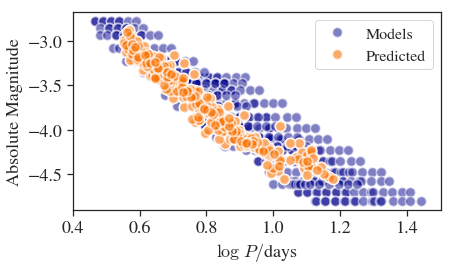

In [49]:
var = 'logL'
mew = 1.8
ms = 20
plt.plot(DF['logP'], -2.5*DF[var].values + 4.77, '.', 
         mfc='white', mec='white', mew=mew, alpha=1, ms=ms)
plt.plot(DF['logP'], -2.5*DF[var].values + 4.77, '.', label='Models', 
         mfc='darkblue', mec='white', mew=mew, alpha=0.5, ms=ms)
plt.plot(logPs, -2.5*ests[:,X_columns.index(var)] + 4.77, '.', 
         mfc='white', mec='white', mew=mew, alpha=1, ms=ms)
plt.plot(logPs, -2.5*ests[:,X_columns.index(var)] + 4.77, '.', label='Predicted', 
         mfc='#F97100', mec='white', mew=mew, alpha=0.6, ms=ms)
plt.xlabel('$\log\;P/$days')
plt.ylabel('Absolute Magnitude')
#plt.ylabel('$\log\;L/$L$_\odot$')
plt.legend(loc='best')
plt.xlim([0.4, 1.5])
plt.savefig('CEP-LMC-PM-predicted.pdf')#, bbox_inches='tight')
plt.show()

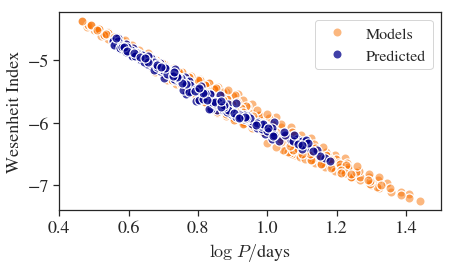

In [50]:
var = 'W'
mew = 1.4
ms = 18
for idx, star in DF.sample(frac=1, random_state=0).iterrows():
    plt.plot(DF['logP'].iloc[idx], DF[var].iloc[idx], '.', 
             mfc='None', mec='white', mew=mew, alpha=1, ms=ms, label='')
    plt.plot(DF['logP'].iloc[idx], DF[var].iloc[idx], '.', label='Models' if idx == 1 else '', 
             mfc='#F97100', mec='None', mew=mew, alpha=0.5, ms=ms-2)
for ii in range(len(logPs)):
    plt.plot(logPs[ii], ests[:,X_columns.index(var)][ii], '.', label='',
             mfc='None', mec='white', mew=mew, alpha=1, ms=ms)
    plt.plot(logPs[ii], ests[:,X_columns.index(var)][ii], '.', label='Predicted' if ii == 1 else '', 
             mfc='darkblue', mec='None', mew=mew, alpha=0.75, ms=ms-2)
plt.xlabel('$\log\;P/$days')
plt.ylabel('Wesenheit Index')
plt.legend(loc='best')
plt.xlim([0.4, 1.5])
plt.savefig('CEP-LMC-W.pdf')#, bbox_inches='tight')
plt.show()

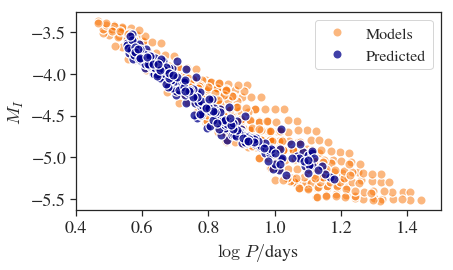

In [51]:
var = 'I_M0'
mew = 1.4
ms = 18
for idx, star in DF.sample(frac=1, random_state=0).iterrows():
    plt.plot(DF['logP'].iloc[idx], DF[var].iloc[idx], '.', 
             mfc='None', mec='white', mew=mew, alpha=1, ms=ms, label='')
    plt.plot(DF['logP'].iloc[idx], DF[var].iloc[idx], '.', label='Models' if idx == 1 else '', 
             mfc='#F97100', mec='None', mew=mew, alpha=0.5, ms=ms-2)
for ii in range(len(logPs)):
    plt.plot(logPs[ii], ests[:,X_columns.index(var)][ii], '.', label='',
             mfc='None', mec='white', mew=mew, alpha=1, ms=ms)
    plt.plot(logPs[ii], ests[:,X_columns.index(var)][ii], '.', label='Predicted' if ii == 1 else '', 
             mfc='darkblue', mec='None', mew=mew, alpha=0.75, ms=ms-2)
plt.xlabel('$\log\;P/$days')
plt.ylabel('$M_I$')
plt.legend(loc='best')
plt.xlim([0.4, 1.5])
plt.savefig('CEP-LMC-I.pdf')#, bbox_inches='tight')
plt.show()

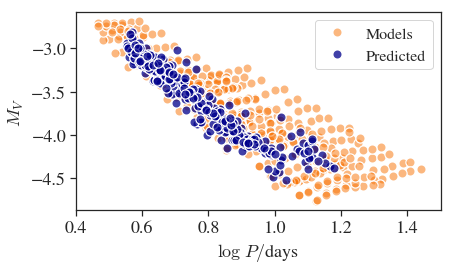

In [52]:
var = 'V_M0'
mew = 1.4
ms = 18
for idx, star in DF.sample(frac=1, random_state=0).iterrows():
    plt.plot(DF['logP'].iloc[idx], DF[var].iloc[idx], '.', 
             mfc='None', mec='white', mew=mew, alpha=1, ms=ms, label='')
    plt.plot(DF['logP'].iloc[idx], DF[var].iloc[idx], '.', label='Models' if idx == 1 else '', 
             mfc='#F97100', mec='None', mew=mew, alpha=0.5, ms=ms-2)
for ii in range(len(logPs)):
    plt.plot(logPs[ii], ests[:,X_columns.index(var)][ii], '.', label='',
             mfc='None', mec='white', mew=mew, alpha=1, ms=ms)
    plt.plot(logPs[ii], ests[:,X_columns.index(var)][ii], '.', label='Predicted' if ii == 1 else '', 
             mfc='darkblue', mec='None', mew=mew, alpha=0.75, ms=ms-2)
plt.xlabel('$\log\;P/$days')
plt.ylabel('$M_V$')
plt.legend(loc='best')
plt.xlim([0.4, 1.5])
plt.savefig('CEP-LMC-V.pdf')#, bbox_inches='tight')
plt.show()

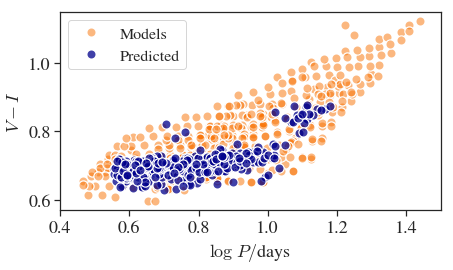

In [53]:
var = 'VI'
mew = 1.4
ms = 18
for idx, star in DF.sample(frac=1, random_state=0).iterrows():
    plt.plot(DF['logP'].iloc[idx], DF[var].iloc[idx], '.', 
             mfc='None', mec='white', mew=mew, alpha=1, ms=ms, label='')
    plt.plot(DF['logP'].iloc[idx], DF[var].iloc[idx], '.', label='Models' if idx == 1 else '', 
             mfc='#F97100', mec='None', mew=mew, alpha=0.5, ms=ms-2)
for ii in range(len(logPs)):
    plt.plot(logPs[ii], ests[:,X_columns.index(var)][ii], '.', label='',
             mfc='None', mec='white', mew=mew, alpha=1, ms=ms)
    plt.plot(logPs[ii], ests[:,X_columns.index(var)][ii], '.', label='Predicted' if ii == 1 else '', 
             mfc='darkblue', mec='None', mew=mew, alpha=0.75, ms=ms-2)
plt.xlabel('$\log\;P/$days')
plt.ylabel('$V - I$')
plt.legend(loc='best')
plt.xlim([0.4, 1.5])
plt.savefig('CEP-LMC-VI.pdf')#, bbox_inches='tight')
plt.show()

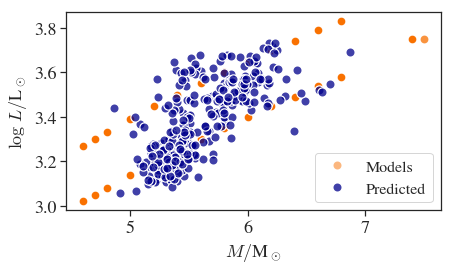

In [54]:
var = 'logL'
mew = 1.4
ms = 18
for idx, star in DF.sample(frac=1, random_state=0).iterrows():
    plt.plot(DF['M'].iloc[idx], DF[var].iloc[idx], '.', 
             mfc='None', mec='white', mew=mew, alpha=1, ms=ms, label='')
    plt.plot(DF['M'].iloc[idx], DF[var].iloc[idx], '.', label='Models' if idx == 1 else '', 
             mfc='#F97100', mec='None', mew=mew, alpha=0.5, ms=ms-2)
for ii in range(len(logPs)):
    plt.plot(ests[:,X_columns.index('M')][ii], ests[:,X_columns.index(var)][ii], '.', label='',
             mfc='None', mec='white', mew=mew, alpha=1, ms=ms)
    plt.plot(ests[:,X_columns.index('M')][ii], ests[:,X_columns.index(var)][ii], '.', label='Predicted' if ii == 1 else '', 
             mfc='darkblue', mec='None', mew=mew, alpha=0.75, ms=ms-2)
plt.ylabel('$\log\;L/$L$_\odot$')
plt.xlabel('$M/$M$_\odot$')
plt.legend(loc='best')
#plt.xlim([0.4, 1.5])
#plt.savefig('CEP-LMC-VI.pdf')#, bbox_inches='tight')
plt.show()

Compare with observations 

In [55]:
V_data = pd.read_table('/scratch/seismo/bellinger/asteroseismology/regression/classical/data/cep_lmc_v.dat', sep='\s+')
I_data = pd.read_table('/scratch/seismo/bellinger/asteroseismology/regression/classical/data/cep_lmc_i.dat', sep='\s+')
evi_data = pd.read_table('evi_lmc_ceph.dat', sep='\s+')

In [56]:
ev_mean_val = evi_data['ev_i'].mean()

In [57]:
from uncertainties import ufloat

actual_Ws = []
e_actual_Ws = []
actual_Is = []
actual_Vs = []
actual_VIs = []
for star_name in tqdm(star_names):
    V = ufloat(V_data[V_data['ID'] == star_name]['A0'].iloc[0], V_data[V_data['ID'] == star_name]['eA0'].iloc[0])
    I = ufloat(I_data[I_data['ID'] == star_name]['A0'].iloc[0], I_data[I_data['ID'] == star_name]['eA0'].iloc[0])
    W = I - 1.55 * (V-I)
    actual_Ws += [W.nominal_value]
    e_actual_Ws += [W.std_dev]
    
    ev = evi_data[evi_data['id'] == star_name]
    if ev.shape[0] == 0:
        ev = ev_mean_val
    else:
        ev = ev.iloc[0]['ev_i']
    #A_V = 2.4*E(V-I)
    #A_I = 1.41*E(V-I)
    actual_Is += [I.nominal_value - 1.41*ev]
    actual_Vs += [V.nominal_value - 2.4*ev]
    actual_VIs += [(V-I).nominal_value]

actual_Ws = np.array(actual_Ws)
e_actual_Ws = np.array(e_actual_Ws)
actual_Is = np.array(actual_Is)
actual_Vs = np.array(actual_Vs)
actual_VIs = np.array(actual_VIs)

In [58]:
mew = 1.4 # marker edge width
ms = 18 # marker size 

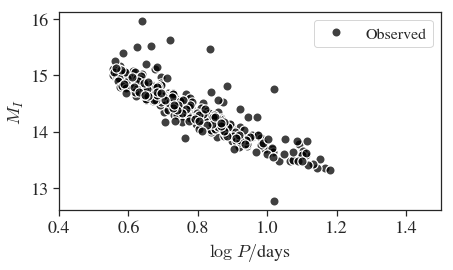

In [59]:
for ii in range(len(logPs)):
    plt.plot(logPs[ii], actual_Is[ii], '.', label='',
             mfc='None', mec='white', mew=mew, alpha=1, ms=ms)
    plt.plot(logPs[ii], actual_Is[ii], '.', label='Observed' if ii == 1 else '', 
             mfc='#000000', mec='None', mew=mew, alpha=0.75, ms=ms-2)

plt.xlabel('$\log\;P/$days')
plt.ylabel('$M_I$')
plt.legend(loc='best')
plt.xlim([0.4, 1.5])
plt.savefig('CEP-LMC-I-obs.pdf')#, bbox_inches='tight')
plt.show()

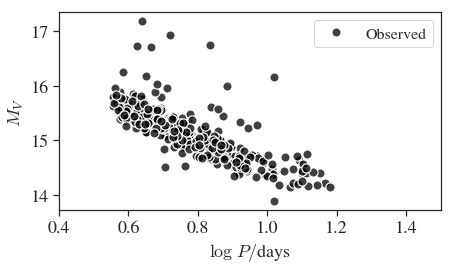

In [60]:
for ii in range(len(logPs)):
    plt.plot(logPs[ii], actual_Vs[ii], '.', label='',
             mfc='None', mec='white', mew=mew, alpha=1, ms=ms)
    plt.plot(logPs[ii], actual_Vs[ii], '.', label='Observed' if ii == 1 else '', 
             mfc='#000000', mec='None', mew=mew, alpha=0.75, ms=ms-2)
plt.xlabel('$\log\;P/$days')
plt.ylabel('$M_V$')
plt.legend(loc='best')
plt.xlim([0.4, 1.5])
plt.savefig('CEP-LMC-V-obs.pdf')
plt.show()

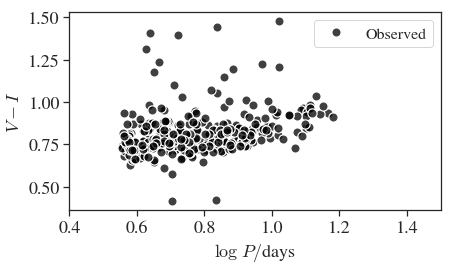

In [61]:
for ii in range(len(logPs)):
    plt.plot(logPs[ii], actual_VIs[ii], '.', label='',
             mfc='None', mec='white', mew=mew, alpha=1, ms=ms)
    plt.plot(logPs[ii], actual_VIs[ii], '.', label='Observed' if ii == 1 else '', 
             mfc='#000000', mec='None', mew=mew, alpha=0.75, ms=ms-2)
plt.xlabel('$\log\;P/$days')
plt.ylabel('$V-I$')
plt.legend(loc='best')
plt.xlim([0.4, 1.5])
plt.savefig('CEP-LMC-VI-obs.pdf')#, bbox_inches='tight')
plt.show()

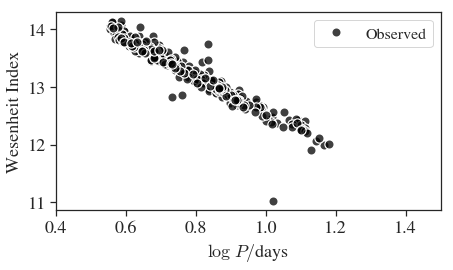

In [62]:
for ii in range(len(logPs)):
    plt.plot(logPs[ii], actual_Ws[ii], '.', label='',
             mfc='None', mec='white', mew=mew, alpha=1, ms=ms)
    plt.plot(logPs[ii], actual_Ws[ii], '.', label='Observed' if ii == 1 else '', 
             mfc='#000000', mec='None', mew=mew, alpha=0.75, ms=ms-2)
plt.xlabel('$\log\;P/$days')
plt.ylabel('Wesenheit Index')
plt.legend(loc='best')
plt.xlim([0.4, 1.5])
plt.savefig('CEP-LMC-W-obs.pdf')#, bbox_inches='tight')
plt.show()

Estimate distances 

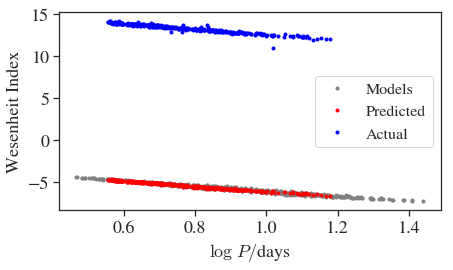

In [63]:
plt.plot(DF['logP'], DF['W'], '.', c='gray', label='Models')
plt.plot(logPs, ests[:,X_columns.index('W')], '.', label='Predicted', c='red')
plt.plot(logPs, actual_Ws, '.', label='Actual', c='blue')
plt.xlabel('$\log\;P/$days')
plt.ylabel('Wesenheit Index')
plt.legend(loc='best')
plt.savefig('CEP-LMC-W-comp.pdf')
plt.show()

In [64]:
from uncertainties import unumpy
# 49.59 +/- 0.09_statistical +/- 0.054_systematic Kpc
pietrzynski = 5 * unumpy.log10(1000*ufloat(49.59, np.sqrt((0.09)**2 + (0.054)**2))) - 5
pietrzynski

18.47697054145555+/-0.0045959169367960516

In [65]:
Ws = ests[:,X_columns.index('W')]
e_Ws = e_ests[:,X_columns.index('W')]

print((actual_Ws - Ws).mean(), '+/-', (actual_Ws -Ws).std())

values = actual_Ws - Ws
weights = 1. / np.sqrt( np.array(e_Ws)**2 + np.array(e_actual_Ws)**2 + 0.89**2 ) 

average = np.average(values, weights=weights)
variance = np.average((values-average)**2, weights=weights)
print(average, '+/-', np.sqrt(variance))

18.683185206153095 +/- 0.1479352628858759
18.68317993439398 +/- 0.14797463537056807


18.688798148600128 +/- 0.09343736583259395


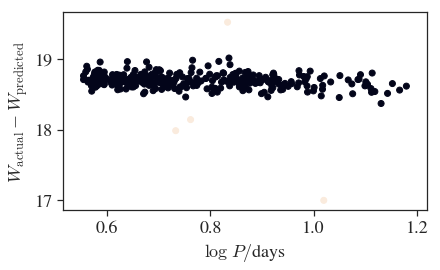

In [66]:
inliers = [True for ii in range(len(actual_Ws))]
while True:
    values = np.array(actual_Ws - ests[:,X_columns.index('W')])
    weights = 1. / np.sqrt( e_ests[:,X_columns.index('W')]**2 + e_actual_Ws**2 + 0.047**2 )**2
    
    average = np.average(values[inliers], weights=weights[inliers])
    variance = np.average((values-average)[inliers]**2, weights=weights[inliers])
    
    new_outliers = np.abs(values[inliers] - average)/np.sqrt(variance) > 5
    if not np.any(new_outliers):
        break
    inliers = np.logical_not(np.abs(values - average)/np.sqrt(variance) > 5)

print(average, '+/-', np.sqrt(variance))

plt.scatter(logPs, actual_Ws - ests[:,X_columns.index('W')], c=np.logical_not(inliers))
#plt.plot(np.array(logPs)[inlier_mask], np.array(actual_Ws - Ws)[inlier_mask], '.')
#plt.plot(np.array(logPs)[outlier_mask], np.array(actual_Ws - Ws)[outlier_mask], '.')

plt.xlabel('$\log\;P/$days')
plt.ylabel('$W_{\\rm{actual}} - W_{\\rm{predicted}}$')
plt.show()

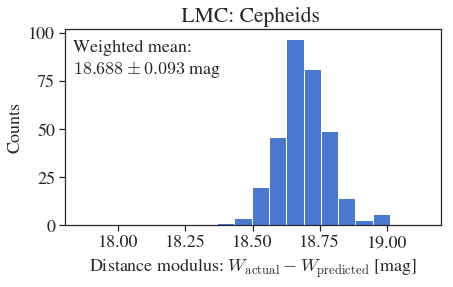

In [67]:
plt.suptitle('         LMC: Cepheids', y=0.99)
plt.hist(np.array(actual_Ws - ests[:,X_columns.index('W')])[inliers])
plt.xlabel('Distance modulus: $W_{\\rm{actual}} - W_{\\rm{predicted}}$ [mag]')
plt.ylabel('Counts')
plt.xlim([17.8, 19.2])
plt.text(17.83, 78, 'Weighted mean:\n$18.688 \pm 0.093$ mag')

plt.savefig('distance_modulus_hist.pdf')
plt.show()

Use random forests to obtain feature importances 

In [68]:
y_col_names = ['$\log\;P$', 
               '$I$ Amplitude', '$I$ Skewness', '$I$ Acuteness',
               '$V$ Amplitude', '$V$ Skewness', '$V$ Acuteness',
               '$I$ $A_1$', '$I$ $A_2$', '$I$ $A_3$',
               '$V$ $A_1$', '$V$ $A_2$', '$V$ $A_3$']

rf = RandomForestRegressor(n_estimators=1024, random_state=1)
X = DF[y_columns]
rf.fit(X, DF['logL'])

importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)

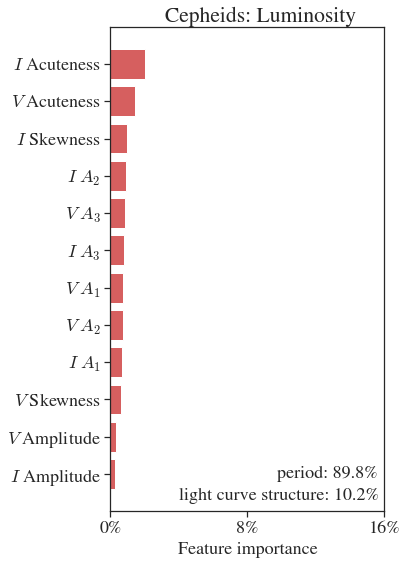

In [69]:
plt.figure(figsize=(6,8))
plt.suptitle('                     Cepheids: Luminosity', y=0.99)
rects1 = plt.barh(range(X.shape[1])[:-1], importances[indices][:-1],
       color="r", #yerr=std[indices][1:], 
                  align="center")
plt.yticks(range(X.shape[1])[:-1], [y_col_names[idx] for idx in indices][:-1])#, rotation='vertical')
plt.ylim([-1, X.shape[1]-1])
plt.xlabel('Feature importance')

plt.xlim([0, 0.16])
ax = plt.gca()
ax.set_xticks([0, 0.08, 0.16])
ax.set_xticklabels(['0%', '8%', '16%'])

plt.text(0.0972, -0.1, 'period: %.1f%%' % (importances[0]*100))
plt.text(0.04,   -0.7, 'light curve structure: %.1f%%' % (sum(importances[1:])*100))

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('%.1f' % (height*100) + '%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), 
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.savefig('CEP-L-importances.pdf')
plt.show()

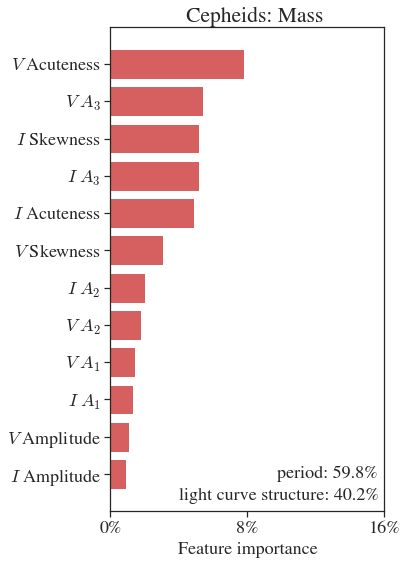

In [70]:
y_col_names = ['$\log\;P$', 
               '$I$ Amplitude', '$I$ Skewness', '$I$ Acuteness',
               '$V$ Amplitude', '$V$ Skewness', '$V$ Acuteness',
               '$I$ $A_1$', '$I$ $A_2$', '$I$ $A_3$',
               '$V$ $A_1$', '$V$ $A_2$', '$V$ $A_3$']

rf = RandomForestRegressor(n_estimators=1024, random_state=1)
X = DF[y_columns]
rf.fit(X, DF['M'])

importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)

plt.figure(figsize=(6,8))
plt.suptitle('                   Cepheids: Mass', y=0.99)
rects1 = plt.barh(range(X.shape[1])[:-1], importances[indices][:-1],
       color="r", #yerr=std[indices][1:], 
                  align="center")
plt.yticks(range(X.shape[1])[:-1], [y_col_names[idx] for idx in indices][:-1])#, rotation='vertical')
plt.ylim([-1, X.shape[1]-1])
plt.xlabel('Feature importance')

plt.xlim([0, 0.16])
ax = plt.gca()
ax.set_xticks([0, 0.08, 0.16])
ax.set_xticklabels(['0%', '8%', '16%'])

plt.text(0.0972, -0.1, 'period: %.1f%%' % (importances[0]*100))
plt.text(0.04,   -0.7, 'light curve structure: %.1f%%' % (sum(importances[1:])*100))

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('%.1f' % (height*100) + '%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), 
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.savefig('CEP-M-importances.pdf')
plt.show()

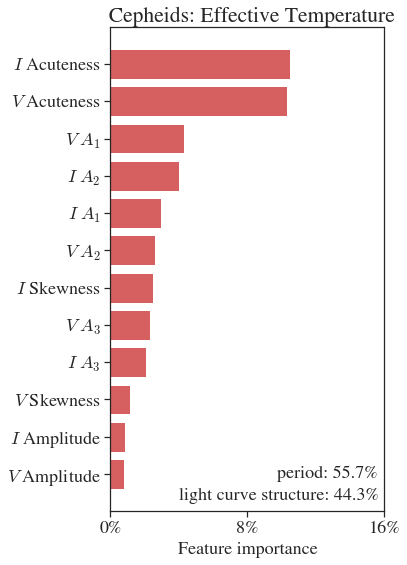

In [71]:
y_col_names = ['$\log\;P$', 
               '$I$ Amplitude', '$I$ Skewness', '$I$ Acuteness',
               '$V$ Amplitude', '$V$ Skewness', '$V$ Acuteness',
               '$I$ $A_1$', '$I$ $A_2$', '$I$ $A_3$',
               '$V$ $A_1$', '$V$ $A_2$', '$V$ $A_3$']

rf = RandomForestRegressor(n_estimators=1024, random_state=1)
X = DF[y_columns]
rf.fit(X, DF['Teff'])

importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)

plt.figure(figsize=(6,8))
plt.suptitle('                  Cepheids: Effective Temperature', y=0.99)
rects1 = plt.barh(range(X.shape[1])[:-1], importances[indices][:-1],
       color="r", #yerr=std[indices][1:], 
                  align="center")
plt.yticks(range(X.shape[1])[:-1], [y_col_names[idx] for idx in indices][:-1])#, rotation='vertical')
plt.ylim([-1, X.shape[1]-1])
plt.xlabel('Feature importance')

plt.xlim([0, 0.16])
ax = plt.gca()
ax.set_xticks([0, 0.08, 0.16])
ax.set_xticklabels(['0%', '8%', '16%'])

plt.text(0.0972, -0.1, 'period: %.1f%%' % (importances[0]*100))
plt.text(0.04,   -0.7, 'light curve structure: %.1f%%' % (sum(importances[1:])*100))

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('%.1f' % (height*100) + '%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), 
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.savefig('CEP-Teff-importances.pdf')
plt.show()

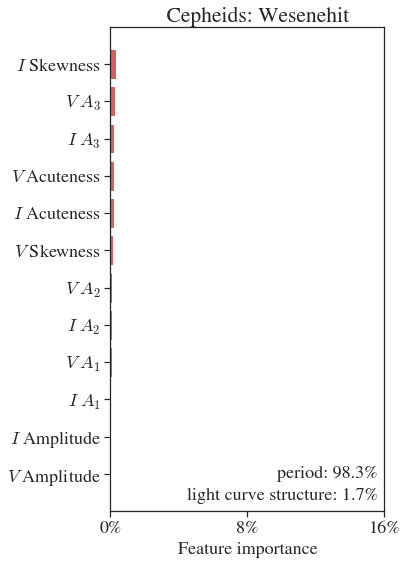

In [72]:
y_col_names = ['$\log\;P$', 
               '$I$ Amplitude', '$I$ Skewness', '$I$ Acuteness',
               '$V$ Amplitude', '$V$ Skewness', '$V$ Acuteness',
               '$I$ $A_1$', '$I$ $A_2$', '$I$ $A_3$',
               '$V$ $A_1$', '$V$ $A_2$', '$V$ $A_3$']

rf = RandomForestRegressor(n_estimators=1024, random_state=1)
X = DF[y_columns]
rf.fit(X, DF['W'])

importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)

plt.figure(figsize=(6,8))
plt.suptitle('                    Cepheids: Wesenehit', y=0.99)
rects1 = plt.barh(range(X.shape[1])[:-1], importances[indices][:-1],
       color="r", #yerr=std[indices][1:], 
                  align="center")
plt.yticks(range(X.shape[1])[:-1], [y_col_names[idx] for idx in indices][:-1])#, rotation='vertical')
plt.ylim([-1, X.shape[1]-1])
plt.xlabel('Feature importance')

plt.xlim([0, 0.16])
ax = plt.gca()
ax.set_xticks([0, 0.08, 0.16])
ax.set_xticklabels(['0%', '8%', '16%'])

plt.text(0.0972, -0.1, 'period: %.1f%%' % (importances[0]*100))
plt.text(0.045,   -0.7, 'light curve structure: %.1f%%' % (sum(importances[1:])*100))

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('%.1f' % (height*100) + '%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), 
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.savefig('CEP-W-importances.pdf')
plt.show()

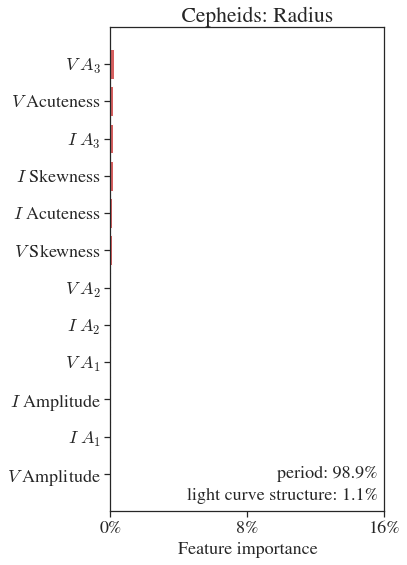

In [73]:
y_col_names = ['$\log\;P$', 
               '$I$ Amplitude', '$I$ Skewness', '$I$ Acuteness',
               '$V$ Amplitude', '$V$ Skewness', '$V$ Acuteness',
               '$I$ $A_1$', '$I$ $A_2$', '$I$ $A_3$',
               '$V$ $A_1$', '$V$ $A_2$', '$V$ $A_3$']

rf = RandomForestRegressor(n_estimators=1024, random_state=1)
X = DF[y_columns]
rf.fit(X, DF['logR'])

importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)

plt.figure(figsize=(6,8))
plt.suptitle('                    Cepheids: Radius', y=0.99)
rects1 = plt.barh(range(X.shape[1])[:-1], importances[indices][:-1],
       color="r", #yerr=std[indices][1:], 
                  align="center")
plt.yticks(range(X.shape[1])[:-1], [y_col_names[idx] for idx in indices][:-1])#, rotation='vertical')
plt.ylim([-1, X.shape[1]-1])
plt.xlabel('Feature importance')

plt.xlim([0, 0.16])
ax = plt.gca()
ax.set_xticks([0, 0.08, 0.16])
ax.set_xticklabels(['0%', '8%', '16%'])

plt.text(0.0972, -0.1, 'period: %.1f%%' % (importances[0]*100))
plt.text(0.045,   -0.7, 'light curve structure: %.1f%%' % (sum(importances[1:])*100))

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('%.1f' % (height*100) + '%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), 
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.savefig('CEP-logR-importances.pdf')
plt.show()

Compare performance of neural network with a random forest 

In [74]:
ml = TransformedTargetRegressor(regressor=Pipeline(
            [('scaler', RobustScaler()), 
             ('mlp', MLPRegressor(hidden_layer_sizes=(100, 100), 
                                  max_iter=2000, activation='relu', solver='lbfgs', tol=1e-7))]),
         transformer=RobustScaler())

lm = LinearRegression()

rf = RandomForestRegressor(n_estimators=1024, random_state=1)

In [75]:
np.random.seed(0) 
cross_val_score(rf, DF[y_columns], DF['M'], cv=ShuffleSplit(n_splits=5, random_state=0), scoring='neg_mean_squared_error').mean()

-0.1271930454254147

In [76]:
np.random.seed(0) 
cross_val_score(ml, DF[y_columns], DF['M'], cv=ShuffleSplit(n_splits=5, random_state=0), scoring='neg_mean_squared_error').mean()

-0.101913586103855

In [77]:
np.random.seed(0) 
cross_val_score(lm, DF[y_columns], DF['M'], cv=ShuffleSplit(n_splits=5, random_state=0), scoring='neg_mean_squared_error').mean()

-0.2947592361576207